# Stage4- 머신러닝을 활용한 모델링 , 하이퍼 파라미터 튜닝 후 결과 적용



In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# 데이터를 불러오고 살펴보기 위한 pandas 라이브러리를 import

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

예측 모델을 돌리기 전에 데이터의 이상값이나 Scew이상치 다중공산성 제거를 해보도록 할게요 이과정이 귀찮아도 나중에 모델이 나왔을때 결과가 더 좋아지거든요!!

우선 데이터를 종류별로 나누어 볼게요!!

참고로 numeric_feature리스트 들은

In [3]:
numeric_feature = ['Age','Departure Delay in Minutes','Arrival Delay in Minutes','Flight Distance']
ordinal_feature = ['Seat comfort', 'Departure/Arrival time convenient', 'Food and drink', 'Gate location', 
           'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 
           'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding']
categorical_feature = ['Gender', 'Customer Type', 'Type of Travel', 'Class']

데이터를 나누어 봣으면 Scew의 정도를 확인해 봐야겠죠??

Scew는 참고로 데이터의 치우침 정도를 보는거랍니다. 데이터가 한쪽으로 편향되어 있으면 모델을 예측하는데 방해가 될수 있을거에요

In [4]:
for xstr in numeric_feature:
  print(xstr,"Scew:",df_train[xstr].skew())

Age Scew: 0.0010456925943488839
Departure Delay in Minutes Scew: 9.190139679910239
Arrival Delay in Minutes Scew: 8.887761727831762
Flight Distance Scew: 0.4509930169224059


Scew를 확인하는법은 위와 같은 코드로 간단하게 알아볼수 있답니다.

시각화로 한번 나타내 볼까요??


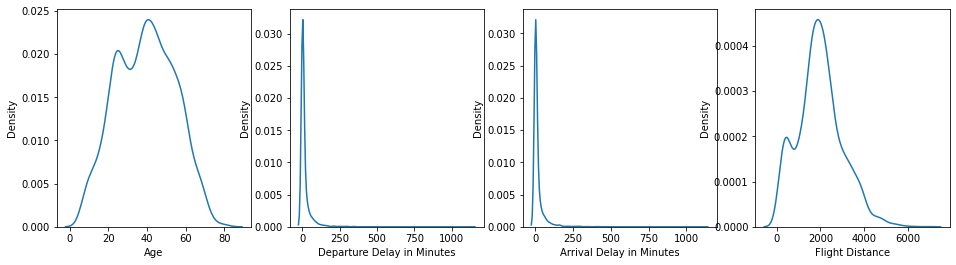

In [5]:
fig, ax = plt.subplots(1, 4,figsize=(16,4))
for xint in range(4):
  sns.kdeplot(x = numeric_feature[xint], data=df_train, ax=ax[xint])

딱 보니 2번쨰 3번째의 값들의 Scew가 한쪽으로 편향된것을 볼수있는데 이경우 log변환을 이용해 값들을 조정해준답니다.

In [6]:
#Departure Delay in Minutes,Arrival Delay in Minutes만 log변환
df_train['Departure Delay in Minutes'] = np.log1p(df_train['Departure Delay in Minutes'])
df_train['Arrival Delay in Minutes'] = np.log1p(df_train['Arrival Delay in Minutes'])

In [7]:
for xstr in numeric_feature:
    print(xstr, "Scew :", df_train[xstr].skew())

Age Scew : 0.0010456925943488839
Departure Delay in Minutes Scew : 0.9302111175258293
Arrival Delay in Minutes Scew : 0.8979015577156512
Flight Distance Scew : 0.4509930169224059


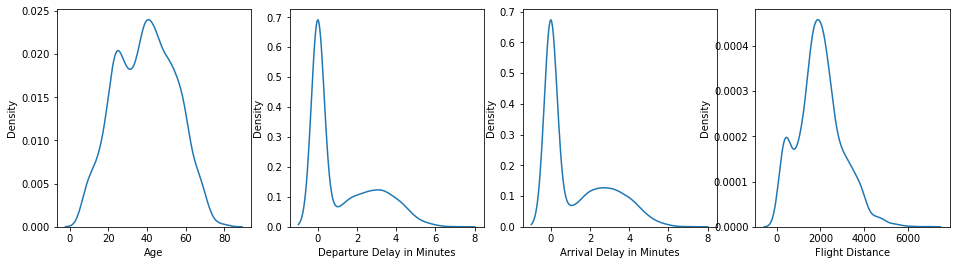

In [8]:
fig, ax = plt.subplots(1, 4, figsize = (16, 4))

for xint in range(4):
    sns.kdeplot(x = numeric_feature[xint], data = df_train, ax = ax[xint])

자 log변환을 하니까 훨씬 편향된 데이터가 고르게 분포를 갖게 되었죠!!

## 다중공산성 제거

다음으로 할일은 다중 공산성을 제거하는 일입니다.

이는 독립변수들간에 강한 상관관계가 나타나는 문제로 이를 해결해 주지 않으면 데이터 분석시 부정적인 영향을 미치는 현상을 말합니다.

여기서 이 부정적인 영향은 정말 어처구니 없는 해석을 하게 만들기도 합니다...

예를 들면 한명의 학생이 두명의 선생님에게 동시에 강의를 듣는다고 생각해보세요 둘다 뛰어난 선생님이지만 강의가 겹치면 전달력이 약해질 겁니다 그런원리입니다!!!

자 그래서 3개의 다중공산성을 제거해 줄겁니다.

상관관계표에서 서로 상관계수가 높은 값들을 제거해주는것입니다.


In [9]:
#다중 공산성 제거
df = df_train.drop(['Food and drink', 'Departure/Arrival time convenient', 'Departure Delay in Minutes'], axis = 1)

성공적으로 제거를 했군요!!!

자!! 다음은 이상치를 확인하고 그값들을 변경시켜주는 과정을 진행하도록 하겠습니다. 함수는 아래와 같이 만들어 주었는데요 25~75%의 값들만 정상치로 나타내고 나머지 범위의 값들은 이상치로 나타내주기위해 빨간색으로 포인트를 찍어봤습니다.

In [10]:
#이상치 알아내기위함 정상범위 출력함수
def outliers_iqr(data):
    q1, q3 = np.percentile(data, [25, 75])
    # 넘파이의 값을 퍼센트로 표시해주는 함수

    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    
    return np.where((data > upper_bound) | (data < lower_bound))

일단 전체적인 모양을 한번 확인해 볼까요??


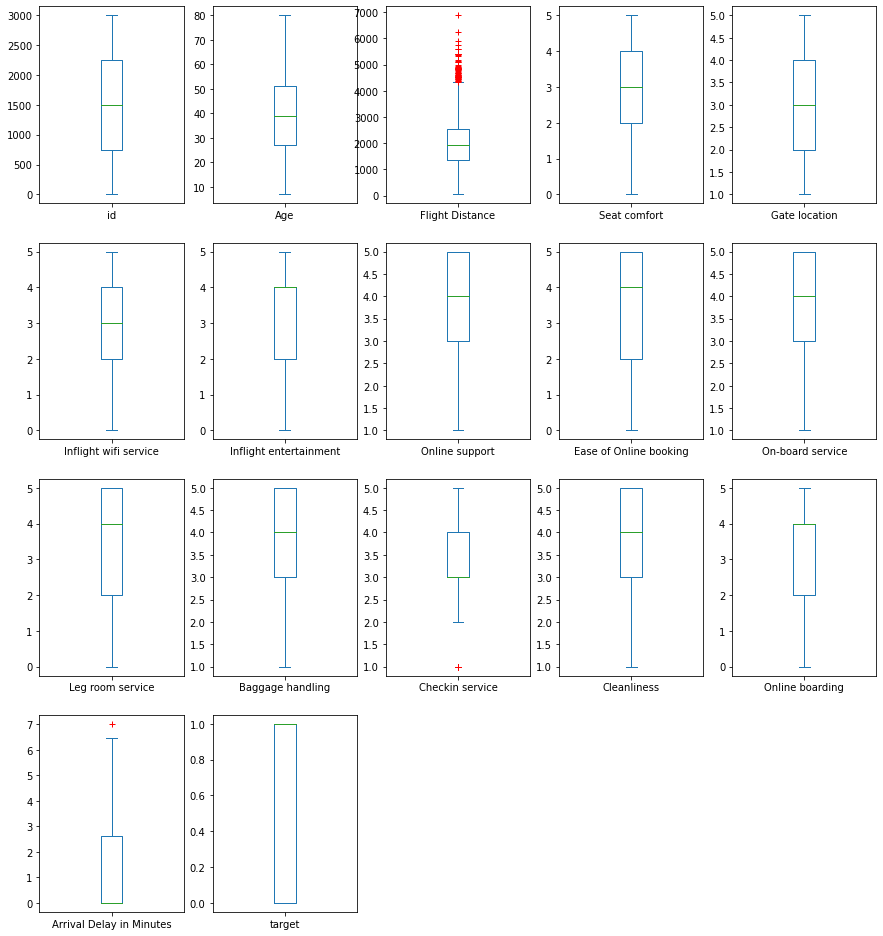

In [11]:
df.plot(kind='box', subplots=True, layout=(5, 5), figsize=(15, 21),sym='r+')
plt.show()       

자 눈에 띄는 이상치 값은 3개의 변수에만 있군요 그 3개의 변수들의 이상치들을 위에서 만든 함수를 적용시켜 그 리스트의 첫번째 값을 저장하는 코드를 짜봣습니다.

In [12]:
ArrivalDelay_index_data = outliers_iqr(df['Arrival Delay in Minutes'])[0]
FlightDistance_index_data = outliers_iqr(df['Flight Distance'])[0]
GarageArea_index_data = outliers_iqr(df['Checkin service'])[0]

자 리스트는 이처럼 구성되어 있습니다.

In [13]:
print(FlightDistance_index_data)

[  77  190  313  322  429  439  456  529  565  570  576  621  648  667
  732  737  889  966 1033 1116 1125 1279 1379 1417 1435 1485 1581 1586
 1663 1675 1737 1743 1754 1760 1809 1836 1859 1915 1924 1954 2087 2118
 2126 2130 2177 2237 2436 2452 2511 2569 2580 2598 2602 2664 2678 2777
 2779 2780]


이상치를 평균값으로 대체 할것인데요 우리는 이때 loc라는 조건문을 사용할겁니다.

In [14]:
df.loc[ArrivalDelay_index_data, 'Arrival Delay in Minutes'] = df['Arrival Delay in Minutes'].mean()
df.loc[FlightDistance_index_data, 'Flight Distance'] = df['Flight Distance'].mean()
df.loc[GarageArea_index_data, 'Checkin service'] = df['Checkin service'].mean()

그림을 보면 이상치값들이 잘 대체가 된것을 볼수가 있습니다.

4천 이상의 데이터는 대체시 예측성능이 떨어져 그대로 냅뒀습니다.

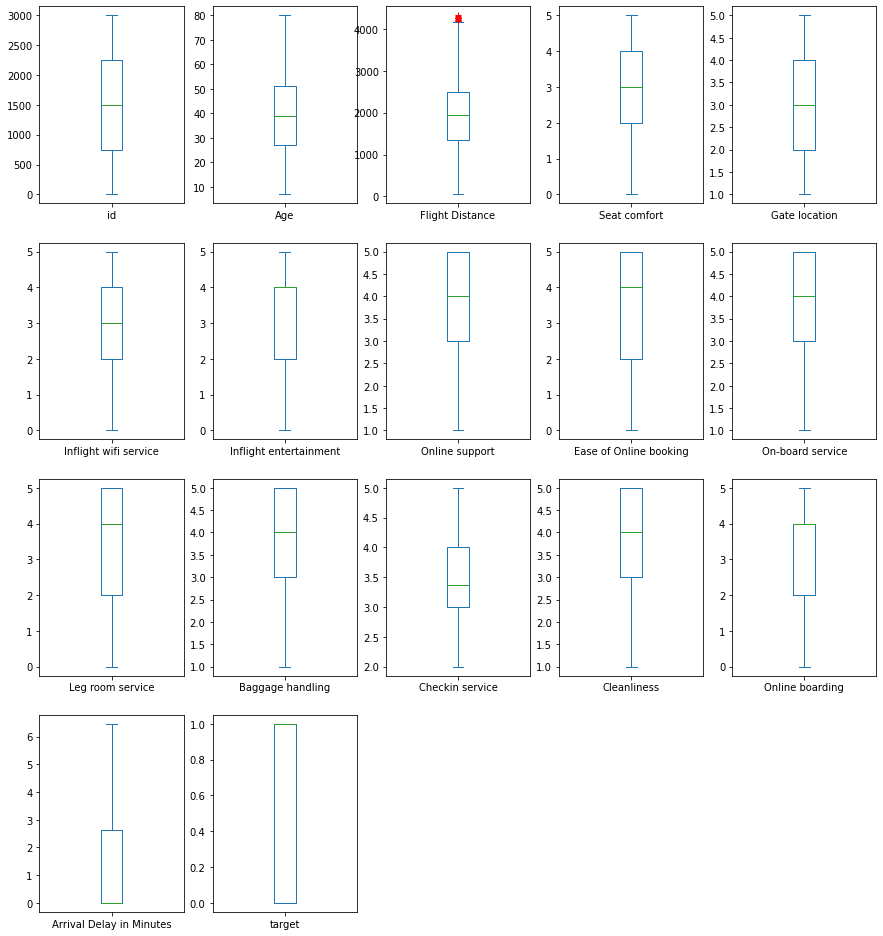

In [15]:
df.plot(kind='box', subplots=True, layout=(5, 5), figsize=(15, 21),sym='r+')
plt.show()       

In [16]:
df.describe()

,id,Age,Flight Distance,Seat comfort,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Arrival Delay in Minutes,target
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.00000,3000.000000,3000.000000,3000.000000,3000.000000,3000.00000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,39.203000,1926.522534,2.863333,3.016667,3.259667,3.352333,3.50500,3.488000,3.497000,3.485000,3.728667,3.63386,3.728667,3.356333,1.268089,0.556000
std,866.169729,15.108802,940.056241,1.394981,1.294713,1.322683,1.352826,1.31068,1.302211,1.283436,1.294218,1.154190,0.94221,1.161678,1.294057,1.630730,0.496937
min,1.000000,7.000000,52.000000,0.000000,1.000000,0.000000,0.000000,1.00000,0.000000,1.000000,0.000000,1.000000,2.00000,1.000000,0.000000,0.000000,0.000000
25%,750.750000,27.000000,1348.250000,2.000000,2.000000,2.000000,2.000000,3.00000,2.000000,3.000000,2.000000,3.000000,3.00000,3.000000,2.000000,0.000000,0.000000
50%,1500.500000,39.000000,1937.000000,3.000000,3.000000,3.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,3.37000,4.000000,4.000000,0.000000,1.000000
75%,2250.250000,51.000000,2483.250000,4.000000,4.000000,4.000000,4.000000,5.00000,5.000000,5.000000,5.000000,5.000000,4.00000,5.000000,4.000000,2.639057,1.000000
max,3000.000000,80.000000,4321.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,6.459904,1.000000


## 머신러닝을 활용한 모델링

데이터 전처리 및 시각화를 통해상관 분석을 해보았는데요

이제는 전처리 된 데이터를 가지고 만족여부를 예측하는 모델을 만들어 볼겁니다. 

저희가 소개할 모델은 로지스틱 회귀, LGBM,XGBOOST,의사결정 나무 모델들을 소개하고 활용하여 예측모델을 만들어 보겠습니다. 이 모델들을 사용하려면 라이브러리를 불러와야 합니다.


## 모델에 대한 이해
그전에 모델에 대한 간략적인 예측 방법에 대해 설명해 드리겟습니다. 

1. 의사결정나무: 특정질문에 따라 데이터를 구분하는 모델로 노드로 구성되어 마지막 리프노드가 가장 섞이지 않은 상태로 분류하는 것이 목표이다.


2. LGBM : 머신러닝 앙상블 기법중 하나인 부스팅에서 나온 모델로 XGB모델의 업그레이드 버전이다. 이는 트리노드로 트리의 모든 노드가 아니라 최종노드 하나만 분할하는 방식으로 구성되어있다.

## 모델 라이브러리 불러오기

In [17]:
from lightgbm import plot_importance, plot_metric,plot_tree
from sklearn.model_selection import train_test_split,cross_validate,GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.tree import DecisionTreeClassifier

## 모델만들어보기
자 모든 모델의 모듈을 불러왔다면 이제 그 모델을 만들어 봐야겠죠???

일단 의사 결정 나무의 모델부터 만들어 보겟습니다.

## 데이터 분할하기
데이터를 분할하는 이유는 특정 데이터로 훈련을 시키고 나머지 데이터로 예측을 하기 위해서 입니다.

In [18]:
## 데이터 분할
X = df.drop(['target'],axis = 1)
Y = df['target']
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=123)#8:2의 훈련세트와 테스트 세트로 난수는 고정을 해줬습니다.
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2400, 20)
(2400,)
(600, 20)
(600,)


8:2비율로 잘 나누어 진것을 볼수 있군요

자 이제 모델을 만들어 볼까요???

그전에 범주형 데이터들을 숫자로 바꾸어줘야 머신러닝 모델이 인지를 하고 학습을 합니다

한번 바꿔볼까요???

## 범주형 숫자형 나누기

In [19]:
categoical_list=[]
numeric_list = []
for i in df.columns:
  if df[i].dtypes == 'O':
    categoical_list.append(i)
  else:
    numeric_list.append(i)

print(categoical_list)
print(numeric_list)

['Gender', 'Customer Type', 'Type of Travel', 'Class']
['id', 'Age', 'Flight Distance', 'Seat comfort', 'Gate location', 'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding', 'Arrival Delay in Minutes', 'target']


자!! 범주형과 숫자형이 잘 나누어 진것을 볼수 있군요 이제 LabelEncoder를 이용해 숫자로 변환해보도록 하겠습니다. 

여기서 범주형 데이터를 숫자형으로 변환하는 모듈이 2개있는데요 LabelEncoder와 one-hot-encoding이 있습니다. 보통 one-hot-encoding은 두개의 범주를 같고있는 데이터에 주로 사용하고 LabelEncoder는 그외의 데이터에 많이 사용하더라구요!! 

In [20]:
from sklearn.preprocessing import LabelEncoder

for col in categoical_list:
  print(col)
  le=LabelEncoder()
  le.fit(list(X_train[col].values) + list(X_test[col].values))
  X_train[col] = le.transform(X_train[col])
  X_test[col] = le.transform(X_test[col])

Gender
Customer Type
Type of Travel
Class


In [21]:
dt= DecisionTreeClassifier(random_state=42)
dt.fit(X_train,y_train)

DecisionTreeClassifier(random_state=42)

In [22]:
print(dt.score(X_train,y_train))

1.0


음 train모델의 점수가 1이 나왔네요. 자 이렇게 되면 모의 고사를 만점을 받았으니 시험도 만점이 나올까요??

In [23]:
print(dt.score(X_test,y_test))

0.8583333333333333


실제 시험의 결과는 85점이죠 이렇게 훈련세트의 점수가 1이 떡하니 나오면 과적합이라고 볼수 있습니다. 무조건 모델의 점수가 높다고 좋은것이 아니에요!!!

일단 의사결정나무가 어떤식으로 분류를 하는지 살펴볼게요!!

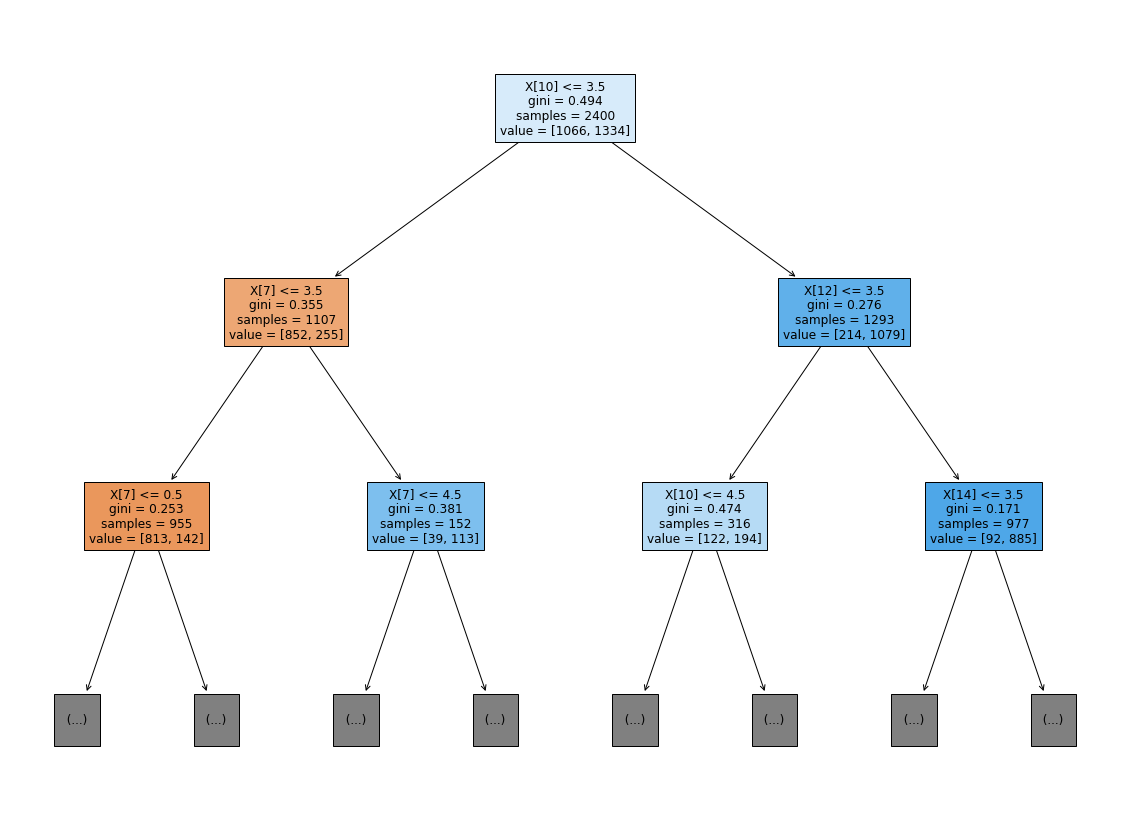

In [24]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(20,15))
plot_tree(dt,max_depth=2,filled=True)
plt.show()

자!! 위그림에서 핵심은 맨 위에있는 노드인데요 

x[5]째 값을 먼저 분류에 사용했군요 이는 그만큼 중요하다는 것을 뜻하는데요 

변수 Inflight entertainment가 가장 중요하다는 것을 알수 있죠 

여기서 알수 있는점은 비행기 안에서의 유흥이 많다면 만족도가 높아 질수 있다는 것을 알수있는거죠!!!

## 결정트리 모델 하이퍼 파리미터 튜닝 해보기

### 하이퍼 파라미터 튜닝 하는이유??
하이퍼 매개 변수 최적화라고도 하는 하이퍼 매개 변수 튜닝은 최상의 성능을 발휘하는 하이퍼 매개 변수 구성을 찾는 프로세스입니다. 따라서 모델의 성능향상을 위해 필요한 과정 이지요! 스코어를 높히는 것이 우리 목표입니다!!

### 하이퍼 파라미터 튜닝

다음은 모델 학습과정에서 꼭 필요한 파라미터 튜닝작업입니다. 튜닝을 통해 모델의 과적합을 방지하고 모델 스코어를 올릴 수 있기 때문에 필수적인 작업입니다. 아래는 Decision Tree의 각 파라미터와 설명입니다. 이외에도 많은 파라미터가 있지만 주로 튜닝하는 파라미터만 준비했습니다. 

criterion: 이론 파트에서 다룬 노드 분리기준입니다. 'gini'와 'entropy'를 사용합니다.

splitter : 노드 분리 방법으로 'random','best'를 사용합니다.

max_depth: 트리 모형의 최대 깊이를 의미하며 값이 커질수록 깊어져 과적합이 쉽게 일어납니다.

min_samples_split: 중간노드에서 분리가 일어나기 위한 샘플의 수입니다. 

min_samples_leaf: leaf 노드에서 필요한 최소한의 샘플 수이며 너무 적으면 과적합이 일어날 수 있습니다.

max_features: 노드를 분리할 때 고려하는 속성의 수입니다. 'int', 'float', 'auto', 'sqrt', 'log2', None값이 들어가며 각 다른 방식으로 계산해 속성의 수를 고려합니다.

random_state: 다른 알고리즘에도 공통으로 들어가는 파라미터로 알고리즘은 실행마다 값이 변하기 때문에 값 변화를 보기 힘듭니다. 하지만 random_state를 고정하면 값 변화를 살펴보고 모델의 성능 개선에 대한 판단을 내릴 수 있습니다. 


자 이제 파라미터 튜닝을 위해 최적을 파라미터를 찾는 GridSearch를 사용해 보겠습니다.

이 모델은 사전에 정의된 모든조합을 탐색해 조합해보고 성능을 알려줍니다. 

이는 시간복잡도가 높고 범위설정을 수동으로 해야한다는 단점이 있습니다.

In [25]:
from sklearn.model_selection import GridSearchCV

# 테스트 하고자 하는 파라미터 값들을 사전 타입으로 정의
dt_clf = DecisionTreeClassifier(random_state=33)
parameters = {
    'max_depth' : [3,5,7],
    'min_samples_split' : [3,5],
    'splitter' : ['best','random']
}

grid_dt = GridSearchCV(dt_clf,
                       param_grid = parameters, cv=5)

grid_dt.fit(X_train,y_train)
result = pd.DataFrame(grid_dt.cv_results_['params'])
result['mean_test_score'] = grid_dt.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score',ascending=False)

,max_depth,min_samples_split,splitter,mean_test_score
9,7,3,random,0.876667
11,7,5,random,0.875417
10,7,5,best,0.866667
8,7,3,best,0.865417
4,5,3,best,0.864167
6,5,5,best,0.864167
5,5,3,random,0.853333
7,5,5,random,0.853333
0,3,3,best,0.851250
2,3,5,best,0.851250


위와같이 최적의 조합을 찾아본 결과 max_depth=7 ,mean_test_score = 3, splitter=random의 조합이 최고의 성능을 보였습니다. 이는 수동적으로 parameters의 조합을 변경해 가며 더욱 더 좋은 값들을 찾을수 있습니다.

---



# LGBM

다음 모델은 LGBM모델입니다.

이또한 모델을 돌리기 위해 LabelEncoding작업을 해줍니다.

In [26]:
#data set나누기
X = df.drop(['target'],axis = 1)
Y = df['target']
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=123)

# 범주형 숫자형 데이터 나누기
categoical_list=[]
numeric_list = []
for i in df.columns:
  if df[i].dtypes == 'O':
    categoical_list.append(i)
  else:
    numeric_list.append(i)

# LabelEncoding
for col in categoical_list:
  print(col)
  le=LabelEncoder()
  le.fit(list(X_train[col].values) + list(X_test[col].values))
  X_train[col] = le.transform(X_train[col])
  X_test[col] = le.transform(X_test[col])

Gender
Customer Type
Type of Travel
Class


In [27]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
clf = lgb.LGBMClassifier()
clf.fit(X_train,y_train)

LGBMClassifier()

clf.fit()로 모델을 train시켜줍니다

# 결과 확인

In [28]:
y_pred = clf.predict(X_test)

In [29]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_pred,y_test)
print('LightGBM model accuracy score: {0:0.4f}'.format(accuracy_score(y_test,y_pred)))

LightGBM model accuracy score: 0.9300


92%의 정확도를 보여줫네요 자 이제 overfitting인지를 확인해 볼까요??

In [30]:
print('Training set score: {:.4f}'.format(clf.score(X_train,y_train)))

print('Test set score: {:.4f}'.format(clf.score(X_test,y_test)))

Training set score: 0.9996
Test set score: 0.9300


#### 위처럼 LGBM모델을 아주 간단하게 만들어 봣는데요 
#### 보통은 위처럼 안만든답니다. 왜냐하면 모델의 params값들을 이용해 모델의 성능이 더 좋아지게 학습을 시키는 튜닝을 해야합니다. 이를 하이퍼 파라미터 튜닝이라고 하는데 이는 파라미터값들로 모델의 성능이 결정되기 때문에 이를 튜닝해주는 과정이죠

## 본래 LGBM모델 생성 및 튜닝 해보기
튜닝은 임의의 값을 넣어 해보고 뒤에서 자세한 설명을 하겠습니다.

###주요파라미터

**num_iterations [default=100]: **반복 수행하려는 트리의 개수를 지정한다. 크게 지정할수록 예측 성능이 높아질 수 있으나, 너무 크게 지정하면 오히려 과적합으로 성능이 저하될 수 있다. 사이킷런 GBM과 XGBoost의 사이킷런 호환 클래스의 n_estimators와 같은 파라미터이므로 LightGBM의 사이킷런 호환 클래스에서는 num_iterations로 이름이 변경되었다.

**learning_rate [default=0.1]:** 0에서 1사이의 값을 지정하며 부스팅 스텝을 반복적으로 수행할 때 업데이트되는 학습률 값이다. 일반적으로 n_estimators를 크게 하고 learning_rate를 작게 해서 예측 성능을 향상시킬 수 있으나, 마찬가지로 과적합 이슈와 학습 시간이 길어지는 부정적인 영향도 고려해야 한다. GBM, XGBoost의 learning_rate와 같은 파라미터이다.

**max_depth [default=-1]: **트리 기반 알고리즘의 max_depth와 같다. 0보다 작은 값을 지정하면 깊이에 제한이 없다. 지금까지 소개한 Depth wise 방식의 트리와 다르게 LightGBM은 Leaf wise 기반이므로 깊이가 상대적으로 더 깊다.

**min_data_in_leaf [default=20]:** 결정 트리의 min_samples_leaf와 같은 파라미터이다. 하지만 사이킷런 래퍼 LightGBM 클래스인 LightGBMClassifier에서는 min_child_samples 파라미터로 이름이 변경된다. 최종 결정 클래스인 리프 노드가 되기 위해서 최소한으로 필요한 레코드 수이며, 과적합을 제어하기 위한 파라미터이다.

**num_leaves [default=31]:** 하나의 트리가 가질 수 있는 최대 리프 개수이다.

**boosting [default=gbdt]:** 부스팅의 트리를 생성하는 알고리즘을 기술한다.

**gbdt **: 일반적인 그래디언트 부스팅 결정 트리

**rf :** 랜덤 포레스트

**bagging_fraction [default=1.0]:** 트리가 커져서 과적합되는 것을 제어하기 위해서 데이터를 샘플링하는 비율을 지정한다. 사이킷런의 GBM과 XGBClassifier의 subsample 파라미터와 동일하기에 사이킷런 래퍼 LightGBM인 LightGBMClassifier에서는 subsample로 동일하게 파라미터 이름이 변경된다.

**feature_fraction [default=1.0]:** 개별 트리를 학습할 때마다 무작위로 선택하는 feature의 비율이다. 과적합을 막기 위해 사용된다. GBM의 max_features와 유사하며, XGBClassifier의 colsample_bytree와 똑같으므로 LightGBM Classifier에서는 동일하게 colsample_bytree로 변경된다.

**lambda_l2 [default=0.0]:** L2 regulation 제어를 위한 값이다. feature 개수가 많을 경우 적용을 검토하며 값이 클수록 과적합 감소 효과가 있다. XGBClassifier의 reg_lambda와 동일하므로 LightGBMClassifier에서는 reg_lambda로 변경된다.

**lambda l1 [default=0.0]:** L1 regulation 제어를 위한 값이다. L2와 마찬가지로 과적합 제어를 위한 것이며, XGBClassifier의 reg_alpha와 동일하므로 LightGBMClassifier에서는 reg_alpha로 변경된다.

## Learning Task 파라미터

objective: 최솟값을 가져야 할 손실함수를 정의한다. Xgboost의 objective 파라미터와 동일하다. 애플리케이션 유형, 즉 회귀, 다중 클래스 분류, 이진 분류인지에 따라서 objective인 손실 함수가 지정된다.

## 하이퍼 파라미터 튜닝 방안

#### num_leaves의 개수를 중심으로 min_child_samples(min_data_in_leaf), max_depth를 함께 조정하면서 모델의 복잡도를 줄이는 것이 기본적인 튜닝의 방안입니다!!


- num_leaves는 개별 트리가 가질 수 있는 최대 리프의 개수이고 LightGBM 모델의 복잡도를 제어하는 주요 파라미커이다. 일반적으로 num_leaves의 개수를 높이면 정확도가 높아지지만, 반대로 트리의 깊이가 깊어지고 모델이 복잡도가 커져 과적합 영향도가 커진다.


- min_data_in_leaf는 사이킷런 래퍼 클래스에서는 min_child_samples로 이름이 바뀐다. 과적합을 개선하기 위한 중요한 파라미터이다. num_leaves와 학습 데이터의 크기에 따라 달라지지만, 보통 큰 값으로 설정하면 트리가 깊어지는 것을 방지한다.


- max_depth는 명시적으로 깊이의 크기를 제한한다. num_leaves, min_data_in_leaf와 결합해 과적합을 개선하는 데 사용한다.


learning_rate를 작게 하면서 n_estimators를 크게 하는 것은 부스팅 계열 튜닝에서 가장 기본적인 튜닝 방안이므로 이를 적용하는 것도 좋지만 n_estimators를 너무 크게 하는 것은 과적합으로 오히려 성능이 저하될 수 있다. 이외에도 과적합을 제어하기 위해 reg_lambda, reg_alpha와 같은 regularization을 적용하거나 학습 데이터를 사용할 feature 개수나 데이터 샘플링 레코드 개수를 줄이기 위해 colsample_bytree, subsample 파라미터를 적용할 수 있다.

parameter값들을 대충 설정하고 해보겠습니다

In [31]:
import lightgbm as lgb

train = lgb.Dataset(X_train, label=y_train)
test = lgb.Dataset(X_test,label=y_test)

params = {
 'n_estimators': 1000,
 'metric': 'l2'
 }
model = lgb.train(params,train, valid_sets = test,num_boost_round=5000,
                  early_stopping_rounds = 125) 

[1]	valid_0's l2: 0.215702
Training until validation scores don't improve for 125 rounds.
[2]	valid_0's l2: 0.190597
[3]	valid_0's l2: 0.168862
[4]	valid_0's l2: 0.151121
[5]	valid_0's l2: 0.136561
[6]	valid_0's l2: 0.124792
[7]	valid_0's l2: 0.115155
[8]	valid_0's l2: 0.106891
[9]	valid_0's l2: 0.10002
[10]	valid_0's l2: 0.0952826
[11]	valid_0's l2: 0.0896655
[12]	valid_0's l2: 0.0850964
[13]	valid_0's l2: 0.0821124
[14]	valid_0's l2: 0.0793335
[15]	valid_0's l2: 0.0768601
[16]	valid_0's l2: 0.0751013
[17]	valid_0's l2: 0.0735222
[18]	valid_0's l2: 0.0723892
[19]	valid_0's l2: 0.0716766
[20]	valid_0's l2: 0.0707675
[21]	valid_0's l2: 0.0697733
[22]	valid_0's l2: 0.0688085
[23]	valid_0's l2: 0.067647
[24]	valid_0's l2: 0.0668398
[25]	valid_0's l2: 0.0660353
[26]	valid_0's l2: 0.064848
[27]	valid_0's l2: 0.0646478
[28]	valid_0's l2: 0.0641972
[29]	valid_0's l2: 0.0634961
[30]	valid_0's l2: 0.0631585
[31]	valid_0's l2: 0.0626556
[32]	valid_0's l2: 0.0624747
[33]	valid_0's l2: 0.0619839
[

In [ ]:
y_pred = model.predict(X_test)
print(y_pred)

아래에서 모델의 예측값들을 0과1로 분류를 해줍니다

0.5보다 큰값이면 1 0.5보다 작은 값이면 0으로 타겟값들을 지정해주는 코드입니다.

In [33]:
from sklearn.metrics import confusion_matrix, accuracy_score

for i in range(len(y_pred)):
  if y_pred[i] >= .5:
    y_pred[i] =1
  else:
    y_pred[i] = 0
cm = confusion_matrix(y_test,y_pred)
accuracy=accuracy_score(y_pred,y_test)
print(cm)

print(accuracy)

[[234  32]
 [ 15 319]]
0.9216666666666666


음 기존보다 떨어진 모델의 성능을 보여줍니다. 이때를 대비해 최적의parameter값들을 찾아 보도록 하겟습니다

## 최적의 params값들 찾기

In [34]:
# params = {
#     'n_estimators' : [100,300,500,1000],
#     'learning_rate' : [0.1,0.05,0.01],
#     'max_depth':[7,8],
#     'colsample_bytree':[0.8,0.9],
#     'subsample':[0.8,0.9],
# }
# gird_search = GridSearchCV(estimator = clf, param_grid= params, cv=3,n_jobs=-1,scoring='accuracy',verbose=2)
# gird_search.fit(X_train ,y_train)

# gird_search.best_score_

# gird_search.best_params_

In [ ]:
import lightgbm as lgb

train = lgb.Dataset(X_train, label=y_train)
test = lgb.Dataset(X_test,label=y_test)

params = {
    'colsample_bytree': 0.9,
 'learning_rate': 0.1,
 'max_depth': 8,
 'n_estimators': 100,
 'metric': 'l2',
 'subsample': 0.8}
model = lgb.train(params,train, valid_sets = test,num_boost_round=6000,
                  early_stopping_rounds = 125) 

In [ ]:
y_pred = model.predict(X_test)
print(y_pred)

In [40]:
from sklearn.metrics import confusion_matrix, accuracy_score

for i in range(len(y_pred)):
  if y_pred[i] >= .5:
    y_pred[i] =1
  else:
    y_pred[i] = 0
cm = confusion_matrix(y_test,y_pred)
accuracy=accuracy_score(y_pred,y_test)
print(cm)

print(accuracy)

[[242  24]
 [ 15 319]]
0.935


최적의 파라미터 조합을 어느정도 신경을 써봣는데요 93.5%의 성능을 가진 모델이 나왔습니다. 생각보다 높죠!! 이정도 올리는 것으로도 아주 성공적인 튜닝이라고 할수 있죠

자!! 여기까지 오느라고 고생많으셨습니다.
이제 우리가 만든 모델을 저장할텐데요!! 이때 pickle을 import 해주어야 합니다

In [41]:
import pickle
saved_model = pickle.dumps(model)

자 위처럼 모델이름을 넣고 모델을 저장 하셧으면 요 밑에 model.predict()안에 예측하고 싶은 데이터 셋을 넣으시면 됩니다!!!

자 여기서 중요한 점은 기존 모델의 전처리 형식이 똑같아야 최대한 비슷한 예측을 하겠죠??

In [ ]:
model = pickle.loads(saved_model)
model.predict()